# LSTM Model

## Armando Bringas
- Student ID: 2023490306
- Status: International Student
- University: Tecnológico de Monterrey
- Location: Querétaro, México

## Alexis Guerrero
- Student ID: 2023480366
- Status: International Student
- University: Universidad de Chile
- Location: Santiago de Chile, Chile

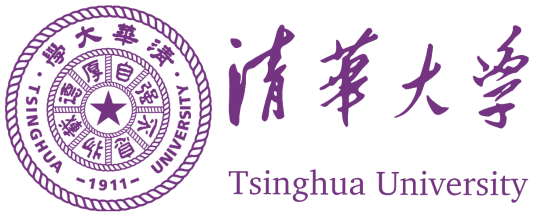

In [69]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import tensor
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import average_precision_score, accuracy_score, classification_report, confusion_matrix, recall_score

In [70]:
# Setting random seed for reproducibility
np.random.seed(42)

# Configuring pandas display options
pd.set_option('display.precision', 2)
pd.set_option('display.float_format', '{:.2f}'.format)

# Determining the default device based on availability
def_device = (
    'mps' if torch.backends.mps.is_available() 
    else 'cuda' if torch.cuda.is_available() 
    else 'cpu'
)

def_device

'cuda'

## Load Data

In [71]:
def load_data_and_filter_ids(file_path):
    """
    Loads data from a CSV file, checks for NaN values in 'step' column grouped by 'series_id',
    and returns a list of 'series_id' values that do not contain NaNs.
    
    :param file_path: Path to the CSV file.
    :return: List of series IDs without NaN values in the 'step' column.
    """
    # Load data from CSV
    train_events = pd.read_csv(file_path)

    # Group by 'series_id' and check for NaN values in 'step' column
    series_has_nan = train_events.groupby('series_id')['step'].apply(lambda x: x.isnull().any())

    # Get list of series IDs that do not contain NaN values
    train_ids = series_has_nan[~series_has_nan].index.tolist()

    return train_ids


file_path = "../data/train_events.csv"
train_ids = load_data_and_filter_ids(file_path)

## Feature Engineering

In [72]:
def get_multi_light_series(series_ids):
    """
    Fetches and processes a dataset for the given series IDs.

    :param series_ids: List of series IDs to fetch.
    :return: Processed DataFrame with added features.
    """
    print(f'Fetching series IDs: {series_ids} \n')
    file_path = "../data/zzzs-lightweight-training-dataset-target/Zzzs_train.parquet"
    multi_series = pd.read_parquet(file_path, filters=[('series_id', 'in', series_ids)])
    multi_series = multi_series.astype({'series_id': 'category', 'step': 'int16', 'awake': 'int16'})
    multi_series = add_features(multi_series)

    return multi_series

def add_features(df):
    """
    Adds various features to the DataFrame.

    :param df: DataFrame to which features are added.
    :return: DataFrame with added features.
    """
    df = add_time_features(df)
    df = add_interaction_features(df)
    df = add_rolling_features(df, periods=6)  # 1/2 minute

    return df

def add_time_features(df):
    """ Adds time-related features to the DataFrame. """
    df["timestamp"] = pd.to_datetime(df["timestamp"], utc=True)
    df["hour"] = df["timestamp"].dt.hour
    df["dayofweek"] = df["timestamp"].dt.dayofweek
    return df

def add_interaction_features(df):
    """ Adds interaction features to the DataFrame. """
    df["anglez_times_enmo"] = abs(df["anglez"]) * df["enmo"]
    return df

def add_rolling_features(df, periods):
    """ Adds rolling features to the DataFrame. """
    # Define operations to be applied
    operations = ["mean", "min", "max", "std"]
    columns = ["anglez", "enmo"]

    for column in columns:
        for operation in operations:
            df[f"{column}_{operation}"] = (
                df[column].rolling(periods, center=True).agg(operation).bfill().ffill().astype('float32')
            )

        # Differential features
        df[f"{column}_diff"] = (
            df.groupby('series_id', observed=True)[column].diff(periods=periods).bfill()
        )
        df[f"{column}_diff_rolling"] = (
            df[f"{column}_diff"].rolling(periods, center=True).mean().bfill().ffill().astype('float32')
        )

    return df


In [73]:
%time train_all = get_multi_light_series(train_ids[:35])
print(f'memory usage: {train_all.memory_usage().sum() / 1024**2: .2f} MB')

Fetching series IDs: ['08db4255286f', '0a96f4993bd7', '0cfc06c129cc', '1087d7b0ff2e', '10f8bc1f7b07', '18b61dd5aae8', '29c75c018220', '31011ade7c0a', '3452b878e596', '349c5562ee2c', '3664fe9233f9', '483d6545417f', '55a47ff9dc8a', '5acc9d63b5fd', '5f94bb3e1bed', '655f19eabf1e', '67f5fc60e494', '72bbd1ac3edf', '76237b9406d5', '7822ee8fe3ec', '89bd631d1769', '8e32047cbc1f', '939932f1822d', '9ee455e4770d', 'a596ad0b82aa', 'a9a2f7fac455', 'a9e5f5314bcb', 'af91d9a50547', 'b364205aba43', 'c535634d7dcd', 'c6788e579967', 'c68260cc9e8f', 'ca730dbf521d', 'd150801f3145', 'd25e479ecbb7'] 



CPU times: total: 52.2 s
Wall time: 1min 13s
memory usage:  968.23 MB


In [74]:
train_all.head()

,series_id,step,timestamp,anglez,enmo,awake,hour,dayofweek,anglez_times_enmo,anglez_mean,...,anglez_max,anglez_std,anglez_diff,anglez_diff_rolling,enmo_mean,enmo_min,enmo_max,enmo_std,enmo_diff,enmo_diff_rolling
0,08db4255286f,0,2018-11-05 14:00:00+00:00,-30.85,0.04,1,14,0,1.38,-33.75,...,-30.85,1.46,0.33,0.33,0.06,0.04,0.08,0.01,0.06,0.06
1,08db4255286f,1,2018-11-05 14:00:05+00:00,-34.18,0.04,1,14,0,1.51,-33.75,...,-30.85,1.46,0.33,0.33,0.06,0.04,0.08,0.01,0.06,0.06
2,08db4255286f,2,2018-11-05 14:00:10+00:00,-33.88,0.05,1,14,0,1.64,-33.75,...,-30.85,1.46,0.33,0.33,0.06,0.04,0.08,0.01,0.06,0.06
3,08db4255286f,3,2018-11-05 14:00:15+00:00,-34.28,0.07,1,14,0,2.33,-33.75,...,-30.85,1.46,0.33,0.33,0.06,0.04,0.08,0.01,0.06,0.06
4,08db4255286f,4,2018-11-05 14:00:20+00:00,-34.39,0.08,1,14,0,2.64,-33.69,...,-30.51,1.60,0.33,0.33,0.07,0.04,0.11,0.02,0.06,0.06


## Data Preprocessing

In [75]:
def scale_features_and_extract_target(df, feature_names, target_name):
    """
    Scales the features of the dataset and extracts the target variable.

    :param df: DataFrame containing the dataset.
    :param feature_names: List of feature names to be scaled.
    :param target_name: Name of the target variable.
    :return: Tuple of scaled features array and target variable array.
    """
    # Initialize the scaler
    scaler = StandardScaler()

    # Scale the features
    df_features_scaled = scaler.fit_transform(df[feature_names])

    # Extract the target variable
    df_target = df[target_name].values

    return df_features_scaled, df_target

In [76]:
features = ["step", "hour", "dayofweek", "anglez_times_enmo",
            "anglez", "anglez_diff", "anglez_mean", "anglez_min", "anglez_max", "anglez_std", "anglez_diff_rolling",
            "enmo", "enmo_diff", "enmo_mean", "enmo_min", "enmo_max", "enmo_std", "enmo_diff_rolling"]
target = 'awake'


df_train_X_scaled, df_train_y = scale_features_and_extract_target(train_all, features, target)

## Split Data

In [77]:
def prepare_data_and_split(df_features, df_target, split_ratio=0.8, convert_to_tensor=True):
    """
    Converts feature and target dataframes into PyTorch tensors and splits them into training and validation sets.

    :param df_features: DataFrame or array containing the feature data.
    :param df_target: DataFrame or array containing the target data.
    :param split_ratio: Float representing the proportion of the dataset to include in the train split.
    :param convert_to_tensor: Boolean 
    :return: Tuples of tensors (X_train, y_train), (X_val, y_val).
    """

    if convert_to_tensor:
        X = tensor(df_features, dtype=torch.float32)
        y = tensor(df_target, dtype=torch.long)
    else:
        X, y = df_features, df_target

    # Split the data
    split_index = int(len(X) * split_ratio)
    X_train, X_val = X[:split_index], X[split_index:]
    y_train, y_val = y[:split_index], y[split_index:]

    return (X_train, y_train), (X_val, y_val)

In [78]:
(X_train, y_train), (X_val, y_val) = prepare_data_and_split(df_train_X_scaled, df_train_y)

# Checking the shapes
print("Train shapes (X, y):", X_train.shape, y_train.shape)
print("Validation shapes (X, y):", X_val.shape, y_val.shape)

Train shapes (X, y): torch.Size([10027296, 18]) torch.Size([10027296])
Validation shapes (X, y): torch.Size([2506824, 18]) torch.Size([2506824])


## Data Loader

In [79]:
class TimeSeriesDataset(Dataset):
    """ Custom Dataset for handling time series data. """
    def __init__(self, X, y):
        self.X, self.y = X, y
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

def create_dataloaders(train_dataset, val_dataset, batch_size, shuffle=False):
    """
    Creates DataLoader objects for training and validation datasets.

    :param train_dataset: Training dataset of type TimeSeriesDataset.
    :param val_dataset: Validation dataset of type TimeSeriesDataset.
    :param batch_size: Batch size for the DataLoader.
    :param shuffle: Boolean indicating whether to shuffle the dataset.
    :return: Tuple of DataLoader objects for training and validation datasets.
    """
    train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
    val_dl = DataLoader(val_dataset, batch_size=batch_size, shuffle=shuffle)
    return train_dl, val_dl

In [80]:
batch_size = 12*60  # 1 hour
train_ds = TimeSeriesDataset(X_train, y_train)
val_ds = TimeSeriesDataset(X_val, y_val)

train_dl, val_dl = create_dataloaders(train_ds, val_ds, batch_size=batch_size, shuffle=False)

## Model

In [81]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        """
        Initialize the LSTM model.

        :param input_size: Number of input features.
        :param hidden_size: Number of features in the hidden state of the LSTM.
        :param num_layers: Number of recurrent layers.
        :param output_size: Number of output features (size of output tensor).
        """
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        
        # Activation function
        self.relu = nn.ReLU()

        # Fully connected layer
        self.fc = nn.Linear(hidden_size * 2, output_size)  # Output size is doubled for bidirectional LSTM
    
    def forward(self, x):
        """
        Forward pass of the LSTM.

        :param x: Input tensor.
        :return: Output tensor.
        """
        batch_size = x.size(0)

        # Initialize hidden and cell states
        h0 = torch.zeros(self.num_layers * 2, batch_size, self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers * 2, batch_size, self.hidden_size).to(x.device)

        # Reshape input to 3D tensor for LSTM
        x = x[:, None, :]  

        # LSTM output
        out, _ = self.lstm(x, (h0, c0))

        # Passing the output through the fully connected layer
        out = self.fc(self.relu(out[:, -1, :])) 

        return out

In [82]:
# Architecture
input_size = len(features)
hidden_size = 64
num_layers = 2
output_size = 2
epochs = 10

model = LSTM(input_size, hidden_size, num_layers, output_size)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_func = F.cross_entropy

model.to(def_device)
model

LSTM(
  (lstm): LSTM(18, 64, num_layers=2, batch_first=True, bidirectional=True)
  (relu): ReLU()
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

## Training & Evaluation

In [83]:
def accuracy(outputs, labels):
    """
    Computes the accuracy of the model.

    :param outputs: Model predictions.
    :param labels: Ground truth labels.
    :return: Accuracy as a float.
    """
    predictions = outputs.argmax(dim=1)
    correct = (predictions == labels)
    return correct.float().mean()

def specificity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)
    return specificity

def plot_confusion_matrix(y_true, y_pred, class_names):
    """
    Plot a confusion matrix.

    :param y_true: True labels.
    :param y_pred: Predicted labels.
    :param class_names: List of class labels.
    """
    # Generate confusion matrix using sklearn
    cm = confusion_matrix(y_true, y_pred)

    # Calculate percentages
    total = cm.sum()
    tn_percentage = (cm[0, 0] / total) * 100
    fp_percentage = (cm[0, 1] / total) * 100
    fn_percentage = (cm[1, 0] / total) * 100
    tp_percentage = (cm[1, 1] / total) * 100

    tn_text = f"{cm[0, 0]} ({tn_percentage:.2f}%)"
    fp_text = f"{cm[0, 1]} ({fp_percentage:.2f}%)"
    fn_text = f"{cm[1, 0]} ({fn_percentage:.2f}%)"
    tp_text = f"{cm[1, 1]} ({tp_percentage:.2f}%)"

    # Print confusion matrix as a table with percentages
    print(f"\nConfusion Matrix:")
    print(f"{'':<20} {'Predicted Negative':<20} {'Predicted Positive':<20}")
    print(f"{'Actual Negative':<20} {tn_text:<20} {fp_text:<20}")
    print(f"{'Actual Positive':<20} {fn_text:<20} {tp_text:<20}")

    # Plot confusion matrix using seaborn
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Purples', xticklabels=class_names, yticklabels=class_names, cbar=False) 

    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

In [84]:
def train(epochs, model, loss_func, optimizer, train_loader, valid_loader, device, classes):
    """
    Trains and evaluates the model.

    :param epochs: Number of epochs to train.
    :param model: The neural network model.
    :param loss_func: Loss function.
    :param optimizer: Optimizer.
    :param train_loader: DataLoader for training data.
    :param valid_loader: DataLoader for validation data.
    :param device: Device to run the model on.
    :param classes: List of class labels.
    :return: Tuple of final loss, accuracy, and predictions.
    """
    for epoch in range(epochs):
        # Training phase
        model.train()
        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/ Training'):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_func(outputs, labels)
            loss.backward()
            optimizer.step()

        # Evaluation phase
        model.eval()
        total_loss, total_acc, count = 0., 0., 0
        y_pred_list = []  # List to store predictions during evaluation
        y_true_list = []  # List to store true labels during evaluation
        y_prob_list = []  # List to store predicted probabilities during evaluation
        with torch.no_grad():
            for inputs, labels in tqdm(valid_loader, desc=f'Epoch {epoch+1}/ Evaluation'):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                count += len(inputs)
                total_loss += loss_func(outputs, labels).item() * len(inputs)
                total_acc += accuracy(outputs, labels).item() * len(inputs)

                # Store predictions, true labels, and predicted probabilities for the current batch
                y_pred_list.append(outputs.argmax(dim=1).cpu().numpy())
                y_true_list.append(labels.cpu().numpy())
                y_prob_list.append(F.softmax(outputs, dim=1).cpu().numpy())

        # Flatten the lists of predictions, true labels, and predicted probabilities
        y_pred = [item for sublist in y_pred_list for item in sublist]
        y_true = [item for sublist in y_true_list for item in sublist]
        y_prob = [item[1] for sublist in y_prob_list for item in sublist]  # Assuming 1 is the positive class

        print(f'Epoch: {epoch+1}, Loss: {total_loss/count:.2f}, Accuracy: {total_acc/count:.2f}')

        # Plot confusion matrix
        plot_confusion_matrix(y_true, y_pred, classes)

        # Calculate and print evaluation scores
        accuracy_value = accuracy_score(y_true, y_pred)
        recall_value = recall_score(y_true, y_pred)
        specificity_value = specificity_score(y_true, y_pred)
        avg_precision_value = average_precision_score(y_true, y_prob)

        print("Classification Report:")
        print(classification_report(y_true, y_pred))
        print(f'Accuracy: {accuracy_value:.2f}')
        print(f'Recall: {recall_value:.2f}')
        print(f'Specificity: {specificity_value:.2f}')
        print(f'Average Precision Score: {avg_precision_value:.2f}')



        partial_eval = 0.4 * specificity_value + 0.3 * recall_value + 0.3 * avg_precision_value
        print(f'Partial evaluation: {partial_eval:.2f}')
        print("\n\n")
              
    return total_loss / count, total_acc / count, y_pred


Epoch 1/ Evaluation: 100%|██████████| 3482/3482 [00:42<00:00, 81.17it/s]


Epoch: 1, Loss: 0.24, Accuracy: 0.91

Confusion Matrix:
                     Predicted Negative   Predicted Positive  
Actual Negative      808837 (32.27%)      34799 (1.39%)       
Actual Positive      194719 (7.77%)       1468469 (58.58%)    


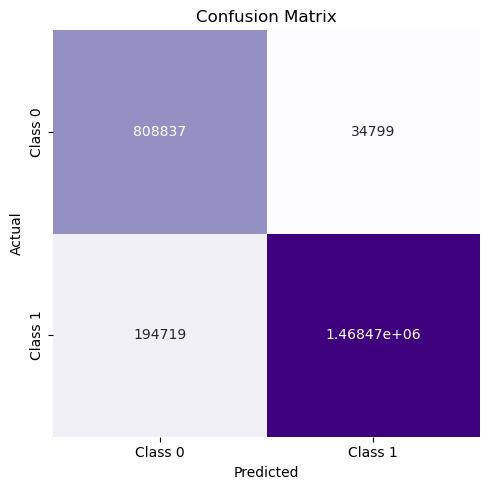

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.96      0.88    843636
           1       0.98      0.88      0.93   1663188

    accuracy                           0.91   2506824
   macro avg       0.89      0.92      0.90   2506824
weighted avg       0.92      0.91      0.91   2506824

Accuracy: 0.91
Recall: 0.88
Specificity: 0.96
Average Precision Score: 0.99
Partial evaluation: 0.94





Epoch 2/ Evaluation: 100%|██████████| 3482/3482 [00:43<00:00, 79.64it/s]


Epoch: 2, Loss: 0.22, Accuracy: 0.92

Confusion Matrix:
                     Predicted Negative   Predicted Positive  
Actual Negative      813470 (32.45%)      30166 (1.20%)       
Actual Positive      178414 (7.12%)       1484774 (59.23%)    


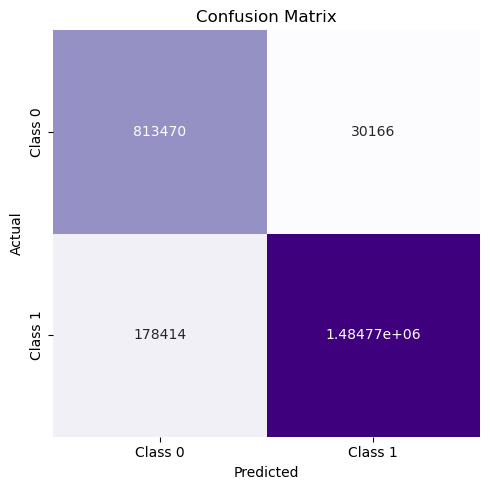

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.96      0.89    843636
           1       0.98      0.89      0.93   1663188

    accuracy                           0.92   2506824
   macro avg       0.90      0.93      0.91   2506824
weighted avg       0.93      0.92      0.92   2506824

Accuracy: 0.92
Recall: 0.89
Specificity: 0.96
Average Precision Score: 0.99
Partial evaluation: 0.95





Epoch 3/ Evaluation: 100%|██████████| 3482/3482 [00:43<00:00, 79.88it/s]


Epoch: 3, Loss: 0.23, Accuracy: 0.91

Confusion Matrix:
                     Predicted Negative   Predicted Positive  
Actual Negative      810024 (32.31%)      33612 (1.34%)       
Actual Positive      182918 (7.30%)       1480270 (59.05%)    


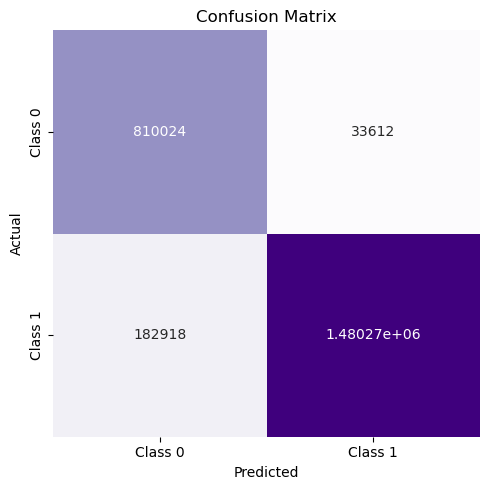

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.96      0.88    843636
           1       0.98      0.89      0.93   1663188

    accuracy                           0.91   2506824
   macro avg       0.90      0.93      0.91   2506824
weighted avg       0.92      0.91      0.92   2506824

Accuracy: 0.91
Recall: 0.89
Specificity: 0.96
Average Precision Score: 0.99
Partial evaluation: 0.95





Epoch 4/ Evaluation: 100%|██████████| 3482/3482 [00:43<00:00, 80.01it/s]


Epoch: 4, Loss: 0.22, Accuracy: 0.92

Confusion Matrix:
                     Predicted Negative   Predicted Positive  
Actual Negative      813183 (32.44%)      30453 (1.21%)       
Actual Positive      175713 (7.01%)       1487475 (59.34%)    


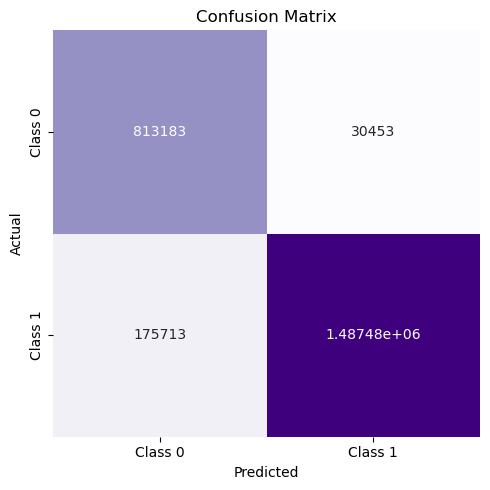

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.96      0.89    843636
           1       0.98      0.89      0.94   1663188

    accuracy                           0.92   2506824
   macro avg       0.90      0.93      0.91   2506824
weighted avg       0.93      0.92      0.92   2506824

Accuracy: 0.92
Recall: 0.89
Specificity: 0.96
Average Precision Score: 0.99
Partial evaluation: 0.95





Epoch 5/ Evaluation: 100%|██████████| 3482/3482 [00:43<00:00, 79.95it/s]


Epoch: 5, Loss: 0.21, Accuracy: 0.92

Confusion Matrix:
                     Predicted Negative   Predicted Positive  
Actual Negative      813841 (32.47%)      29795 (1.19%)       
Actual Positive      165645 (6.61%)       1497543 (59.74%)    


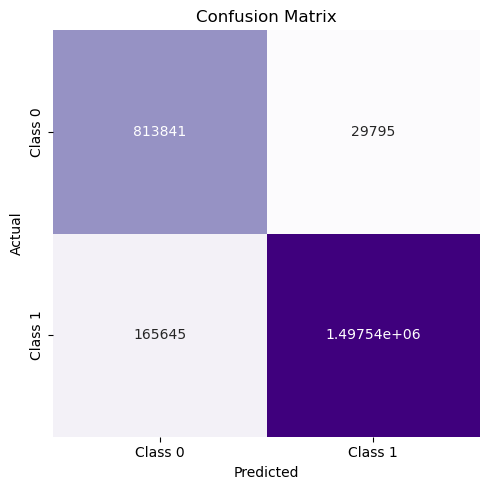

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.96      0.89    843636
           1       0.98      0.90      0.94   1663188

    accuracy                           0.92   2506824
   macro avg       0.91      0.93      0.92   2506824
weighted avg       0.93      0.92      0.92   2506824

Accuracy: 0.92
Recall: 0.90
Specificity: 0.96
Average Precision Score: 0.99
Partial evaluation: 0.95





Epoch 6/ Evaluation: 100%|██████████| 3482/3482 [00:43<00:00, 79.91it/s]


Epoch: 6, Loss: 0.21, Accuracy: 0.92

Confusion Matrix:
                     Predicted Negative   Predicted Positive  
Actual Negative      814717 (32.50%)      28919 (1.15%)       
Actual Positive      171046 (6.82%)       1492142 (59.52%)    


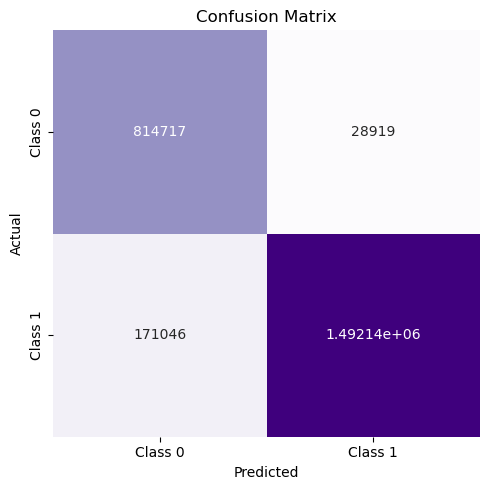

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.97      0.89    843636
           1       0.98      0.90      0.94   1663188

    accuracy                           0.92   2506824
   macro avg       0.90      0.93      0.91   2506824
weighted avg       0.93      0.92      0.92   2506824

Accuracy: 0.92
Recall: 0.90
Specificity: 0.97
Average Precision Score: 0.99
Partial evaluation: 0.95





Epoch 7/ Evaluation: 100%|██████████| 3482/3482 [00:43<00:00, 79.40it/s]


Epoch: 7, Loss: 0.21, Accuracy: 0.92

Confusion Matrix:
                     Predicted Negative   Predicted Positive  
Actual Negative      814157 (32.48%)      29479 (1.18%)       
Actual Positive      168845 (6.74%)       1494343 (59.61%)    


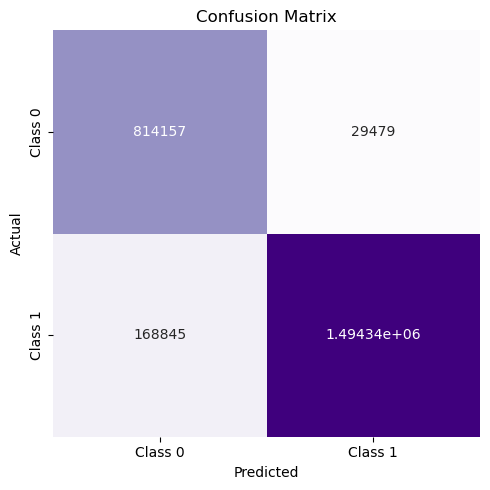

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.97      0.89    843636
           1       0.98      0.90      0.94   1663188

    accuracy                           0.92   2506824
   macro avg       0.90      0.93      0.91   2506824
weighted avg       0.93      0.92      0.92   2506824

Accuracy: 0.92
Recall: 0.90
Specificity: 0.97
Average Precision Score: 0.99
Partial evaluation: 0.95





Epoch 8/ Evaluation: 100%|██████████| 3482/3482 [00:43<00:00, 79.36it/s]


Epoch: 8, Loss: 0.21, Accuracy: 0.92

Confusion Matrix:
                     Predicted Negative   Predicted Positive  
Actual Negative      814280 (32.48%)      29356 (1.17%)       
Actual Positive      168976 (6.74%)       1494212 (59.61%)    


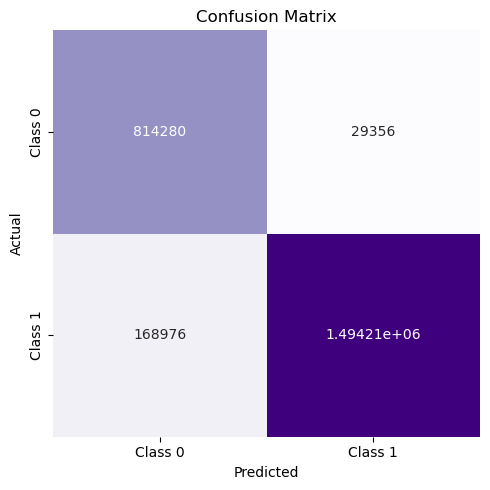

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.97      0.89    843636
           1       0.98      0.90      0.94   1663188

    accuracy                           0.92   2506824
   macro avg       0.90      0.93      0.91   2506824
weighted avg       0.93      0.92      0.92   2506824

Accuracy: 0.92
Recall: 0.90
Specificity: 0.97
Average Precision Score: 0.99
Partial evaluation: 0.95





Epoch 9/ Evaluation: 100%|██████████| 3482/3482 [00:44<00:00, 79.07it/s]


Epoch: 9, Loss: 0.21, Accuracy: 0.92

Confusion Matrix:
                     Predicted Negative   Predicted Positive  
Actual Negative      814360 (32.49%)      29276 (1.17%)       
Actual Positive      168327 (6.71%)       1494861 (59.63%)    


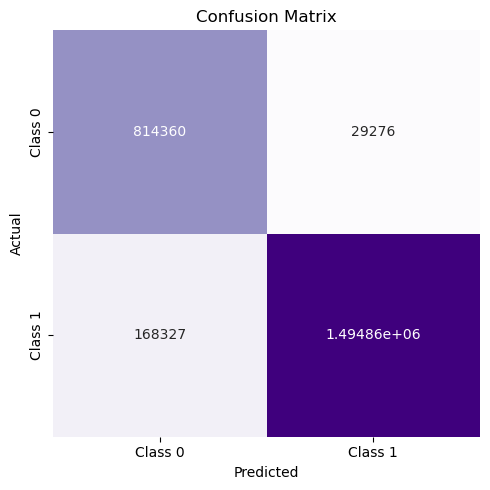

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.97      0.89    843636
           1       0.98      0.90      0.94   1663188

    accuracy                           0.92   2506824
   macro avg       0.90      0.93      0.91   2506824
weighted avg       0.93      0.92      0.92   2506824

Accuracy: 0.92
Recall: 0.90
Specificity: 0.97
Average Precision Score: 0.99
Partial evaluation: 0.95





Epoch 10/ Evaluation: 100%|██████████| 3482/3482 [00:43<00:00, 79.25it/s]


Epoch: 10, Loss: 0.21, Accuracy: 0.92

Confusion Matrix:
                     Predicted Negative   Predicted Positive  
Actual Negative      815089 (32.51%)      28547 (1.14%)       
Actual Positive      168554 (6.72%)       1494634 (59.62%)    


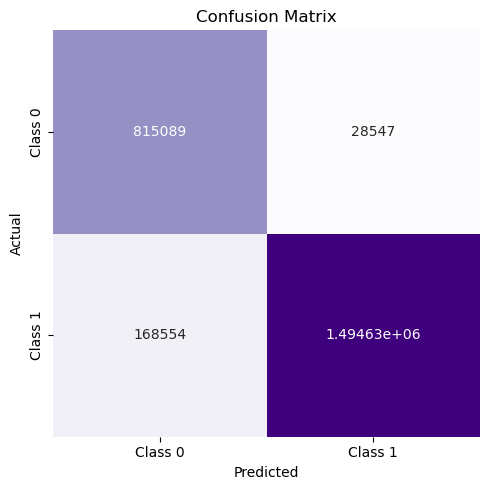

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.97      0.89    843636
           1       0.98      0.90      0.94   1663188

    accuracy                           0.92   2506824
   macro avg       0.90      0.93      0.92   2506824
weighted avg       0.93      0.92      0.92   2506824

Accuracy: 0.92
Recall: 0.90
Specificity: 0.97
Average Precision Score: 0.99
Partial evaluation: 0.95





In [85]:
labels = ["Class 0", "Class 1"]
loss, acc, y_pred = train(epochs, model, loss_func, optimizer, train_dl, val_dl, def_device, labels)